# 04-STATOR PERMANENT MAGNET MOTOR EXAMPLE<img src="logo.png" style="float:right; max-width: 180px; display: inline" alt="logo" /></a>

# Motor estimation models with dimensional analysis and sensitivity/dependency analysis
*Originally written by Aurelien Reysset, INSA Toulouse, France*<br>

## 1 - Introduction
<a id="1"></a>

Motor design is carried out by specialists and depend on the fullfilled missions. Even considering a defined set of materials, geometry can be adapted with a lot of internal parametrized components forms to answer performance needs. Here, those needs will be limited to different diameters (integration limit), speed limits (high/low speed demand) and thermal conductivity factors (high/low dynamics applications) with a common objective: optimizing linear-torque density.

At the early stages of a project assesment, it is combersome to handle lots of parameters and high-fidelity models (long simulation time). Therefore, in this Notebook, we will see how we can reduce problem complexity even before constructing response surface on the complete set of dimensionless parameters.

First we will analyse problem dimensionnality to work only with dimensionless parameters, then we will provide a FEM model within FEMM software using a python script to design and calculate motor performances (used to calculate the set used for sensitivity analysis), and finally the sensitivity and dependency analysis using SizingLab tools will be presented.

<font color=blue>Table of contents:</font><br>
[1 - Introduction](#1-Introduction)<br>
[2 - Dimensional analysis](#2)<br>
[3 - Specialist optimized design with FEMM](#3)<br>
[4 - Analyse $\pi$ sensitivity on reduced DOE](#4)<br>

## 2 - Dimensional analysis [§](#1)
<a id="2"></a>

The main design parameters for a permanent magnet motor are summed-up in next table:

|   Parameter     | Description  | Units |
| -------------- | --------------| -----------|
|$D_E$|External stator diameter|[mm]|
|$D_I$|Internal stator diameter|[mm]|
|$e_{tooth}$|Tooth thikness|[mm]|
|$e_{yoke}$|Tooth thikness|[mm]|
|$W_{PM}$|Permanent magnet width|[mm]|
|$R_I$|Rotor internal radius|[mm]|
|$J$|Winding current density|[A/m²]|
|$B_R$|Permanent magnet remanence|[tesla]|
|$B_{SAT}$|Iron induction saturation|[tesla]|
|$\mu_0$|Vacuum permeability|[H/m]|
| |
|$T_L$|Linear torque|[N]|
| |
|$P_{J,L}$|Linear joule losses|[W/m]|
|$\rho_{WIND}$|Linear winding resistivity|[Ohm.m]|
|$S_{WIND}$|Winding total cross section|[mm²]|

<figcaption>Tab.1 - SPM design parameters.</figcaption>


<figure>
    <img src="./04_motor_example/spm_geometry.png" alt="SPM_geometry" style="height:200px">
    <figcaption>Fig.1 - SPM motor geometry.</figcaption>
</figure>

> Note: perform a dimensional analysis on linear torque using SizingLab Buckingham function.

In [1]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet
from pyvplm.addon.variablepowerlaw import buckingham_theorem

# Define SPM design parameters
d_e = PositiveParameter('d_e',[50,500],'mm','External stator diameter')
d_i = PositiveParameter('d_i',[20,300],'mm','Internal stator diameter')
e_tooth = PositiveParameter('e_tooth',[3,60],'mm','Tooth thikness')
e_yoke = PositiveParameter('e_yoke',[2,20],'mm','Yoke thikness')
w_pm = PositiveParameter('w_pm',[2,20],'mm','Permanent magnet width')
r_i = PositiveParameter('r_i',[5,100],'mm','Rotor internal radius')
j = PositiveParameter('j',[0.1,1000],'A/m**2','Winding current density')
B_R = PositiveParameter('B_R',[1.1],'tesla','Permanent magnet remanence')
B_SAT = PositiveParameter('B_SAT',[0.02],'tesla','Iron induction saturation')
MU_0 = PositiveParameter('MU_0',[1.26e-6],'H/m','Vacuum permeability')
t_l = PositiveParameter('t_l',[0.01,100],'N','Linear torque')
parameter_set = PositiveParameterSet(d_e,d_i,e_tooth,e_yoke,w_pm,r_i,j,B_R,B_SAT,MU_0,t_l)

# Perform dimensional analysis on linear torque
pi_set, _ = buckingham_theorem(parameter_set, False)
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

> Note: perform similar analysis but that time applied to joule losses.

In [2]:
# Define new parameters for joule losses definition
p_jl = PositiveParameter('p_jl',[0.01,1000],'W/m','Linear joule losses')
RHO_WIND = PositiveParameter('RHO_WIND',[17000],'ohm*m','Linear winding resistivity')
s_wind = PositiveParameter('s_wind',[1,100],'mm**2','Winding total cross section')
parameter_set = PositiveParameterSet(d_e,d_i,e_tooth,e_yoke,w_pm,r_i,j,B_R,B_SAT,MU_0,RHO_WIND,s_wind,p_jl)

# Perform dimensional analysis on joule losses
pi_set, _ = buckingham_theorem(parameter_set, False)
pi_set.latex_render()

Defined set is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The retained $\Pi$ parameters have been arranged and numbered in the followin table:

|Parameter|$\pi_{0,1}$|$\pi_{0,2}$|$\pi_1$|$\pi_2$|$\pi_3$|$\pi_4$|$\pi_5$|$\pi_6$|$\pi_7$|
| --------|-----------|-----------|-------|-------|-------|-------|-------|-------|-------|
|Expression|$\frac{T_L}{B_{SAT} \cdot d_e^3 \cdot J}$|$\frac{P_{J,L}}{\rho_{WIND} \cdot S_{wind} \cdot J^2}$|$\frac{\mu_0 \cdot d_e \cdot J}{B_{SAT}}$|$\frac{D_i}{D_e}$|$\frac{e_{tooth}}{\frac{\pi.D_e}{N}}$|$\frac{e_{yoke}}{\frac{\pi.D_e}{N}}$|$\frac{W_{PM}}{D_e}$|$\frac{R_i}{D_e}$|$\frac{B_r}{B_{SAT}}=cste$|

<figcaption>Tab.2 - SPM pi parameters.</figcaption>

The adaptation of $\pi_3$ and $\pi_4$ leads to more sense since term $\frac{\pi.D_e}{N}$ is motor step.
One last primary parameter that should be estimated is iron losses which is partly due to hysteresis losses and the other part to eddy current losses in the stator core.

$P_{eddy}[W/kg]=\frac{\pi^2.B[tesla]^2.d[m]^2.f[Hz]^2}{6.\rho_{iron}[Ohm.m].d_{iron}[kg/m^3]}$ with $d$ the laminate thikness, $f$ the switching frequency proportional to rotational speed $\omega$, $\rho_{iron}$ and $d_{iron}$ material properties (resistivity and density).

This can be expressed into volumic/linear losses:
$P_{e,v}[W/m^3]=\frac{\pi^2.B[tesla]^2.d[m]^2.f[Hz]^2}{6.\rho_{iron}[Ohm.m]} \implies P_{e,l}[W/m]=k_e.B^2.d^2.f^2.S_{iron}$

The volumic losses due to hysteresis derive from Steinmetz's equation:
$P_{h,v}[W/m^3]=k_h.f[Hz]^a.B[tesla]^b \implies P_{h,l}[W/m]=S_{iron}.k_h.f[Hz]^a.B[tesla]^b$ with $k_h$, $a$ and $b$ fitted with material hysteresis properties ($a \approx 1$ and $b \approx 2$ for pure hysteresis).

But the combination of both fenomena can be hard to express into power-form. Therefore we will consider that global linear iron losses will be of the form [*1*]:
$P_{FE,l}= P_{e,l}+ P_{h,l} \propto \Delta p_{1/50}.f^{1.5}.B^2.d_{iron}.S_{iron}$

Therefore, we will consider following parameter $\pi_{0,3}$: $\frac{P_{FE,l}}{\Delta p_{1/50}.\omega_{max}^{1.5}.B_R^2.d_{iron}.D_e^2}$

Similar approach is conducted on joule losses dimensionless parameter $\pi_{0,2}$ transformed to: $\frac{P_{J,l}}{\rho_{WIND}.D_e^2.J^2}$

Another dimentional ratio should be added to the sensitivity analysis if eddy current is considered: $\pi_8=\frac{d}{D_e}$. Yet, considering for a motor range that iron laminate wont change, it can be omitted.

*[1] J. F.Gieras. Permanent Magnet Technology. 2002*

## 3 - Specialist optimized design with FEMM [§](#1)
<a id="3"></a>

Let us consider that to cover a wide range of mobility application cases the specialist may address different range of values on 3 main performance criteria:
* $D_e \in [30,150]mm$, external motor diameter
* $h \in [24.22, 363]W/m^2/K$, stator convection coefficient
* $\omega_{max} \in [2100, 8400]rpm$, motor maximum rotational speed

Embeded system autonomy/efficiency is highly impact by embedded mass, therefore objective optimisation will be torque density.

As designer as to deal with a lot of geometry ratios, we will try, even before constructing reponse surface on defined $\pi_0$ parameters to limit the number of influence $\pi$ parameters.

To do so, we will process with a first step of generation of limited set of optimal motor to cover $D_e$-$h$-$\omega_{max}$ design space and then analyse $\pi$ impact on $\pi_0$ performance parameters.

Therefore, let us first construct a fullfactorial design space with 3-levels (to limit false linear correlation).

Text(0.5, 0, '$\\omega_{max}$')

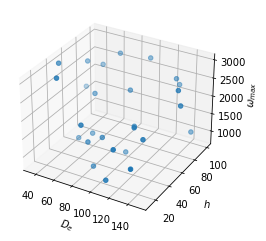

In [3]:
# Import DOE function and numpy/pandas library
from pyDOE2 import lhs
import numpy
import pandas
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plot

# Calculate levels
bounds = numpy.array([[30,150],[10,100],[750,3000]])
doe_levels = lhs(3, samples=27, criterion='maximin', random_state=42)
doe = bounds[:,0] + doe_levels / doe_levels.max(axis = 0) * (bounds[:, 1] - bounds[:, 0])

# Show matrix
doe_data = pandas.DataFrame(doe,columns=['d_e','h','omega_max'])
doe_data.to_excel('./04_motor_example/output.xlsx')
doe_data.head(n=numpy.shape(doe)[0])

# Plot 3D figure
fig = plot.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(doe[:,0], doe[:,1], doe[:,2])
ax.set_xlabel('$D_e$')
ax.set_ylabel('$h$')
ax.set_zlabel('$\omega_{max}$')

Once this DOE has been constructed, geometries should be optimized to fullfill the 3 mentioned requirements.
To do so, a specific code file was developped and runned within an evolutionary optimization loop highlighting multi-start capabilities.
This leaded to the result file presented in the next section.

## 4 - Analyse $\pi$ sensitivity and dependency on reduced DOE [§](#1)
<a id="4"></a>
To skip directly to sensitivity and dependency analysis saving time since work has already been done, we will load **saved_results.xls** file.

In [4]:
import pandas
doe = pandas.read_excel('./04_motor_example/saved_results.xls')
doe.head(n=5)

,pi01,pi02,pi03,pi1,pi2,pi3,pi4,pi5,pi6
0,0.004301,0.056312,0.237982,1.107965,0.350400,0.289153,0.160046,0.035867,0.272200
1,0.004281,0.057047,0.236587,1.099115,0.349733,0.284569,0.160046,0.033000,0.273333
2,0.004378,0.056628,0.244129,1.099115,0.338333,0.284569,0.156608,0.036333,0.259867
3,0.004592,0.061818,0.276087,1.594690,0.323133,0.307105,0.183346,0.064400,0.216533
4,0.004326,0.059516,0.238546,0.760177,0.357267,0.256303,0.132926,0.029200,0.288800


In [5]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet

# Declare directly the pi_set problem
doePI = doe[['pi01','pi02','pi03','pi1','pi2','pi3','pi4','pi5','pi6']].values
pi1 = PositiveParameter('pi1',[0.1,1],'','t_l*b_r**-1*j**-1*d_e**-3')
pi2 = PositiveParameter('pi2',[0.1,1],'','p_j*rho_win**-1*d_e**-2*j**-2')
pi3 = PositiveParameter('pi3',[0.1,1],'','p_fe*delta_p**-1*omega_max**1.5*b_r**-2*d_iron**-1*d_e**-2')
pi4 = PositiveParameter('pi4',[0.1,1],'','mu_0*j*d_e*b_r**-1')
pi5 = PositiveParameter('pi5',[0.1,1],'','d_i*d_e**-1')
pi6 = PositiveParameter('pi6',[0.1,1],'','e_tooth*d_e**-1*n')
pi7 = PositiveParameter('pi7',[0.1,1],'','e_yoke*d_e**-1*n')
pi8 = PositiveParameter('pi8',[0.1,1],'','w_pm*d_e**-1')
pi9 = PositiveParameter('pi9',[0.1,1],'','r_i*d_e**-1')
pi_set = PositiveParameterSet(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9)

In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

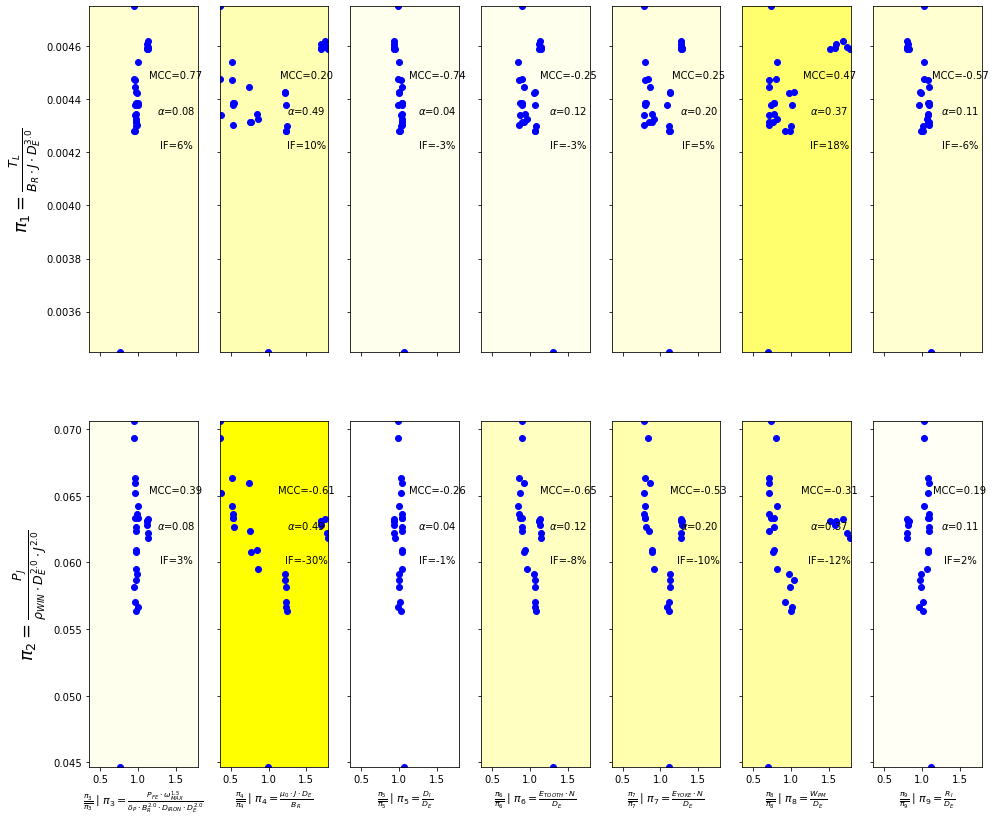

In [7]:
# Change matplotlib visualisation parameter
%matplotlib inline

# Import Sizing Lab modules
from pyvplm.addon.variablepowerlaw import pi_sensitivity

# Perform sensitivity analysis
pi_sensitivity(pi_set, doePI, use_widgets=True)

> Note: parameters $\pi_4$, $\pi_7$ should be kept for $\pi_0$ model regression and DOE generation.

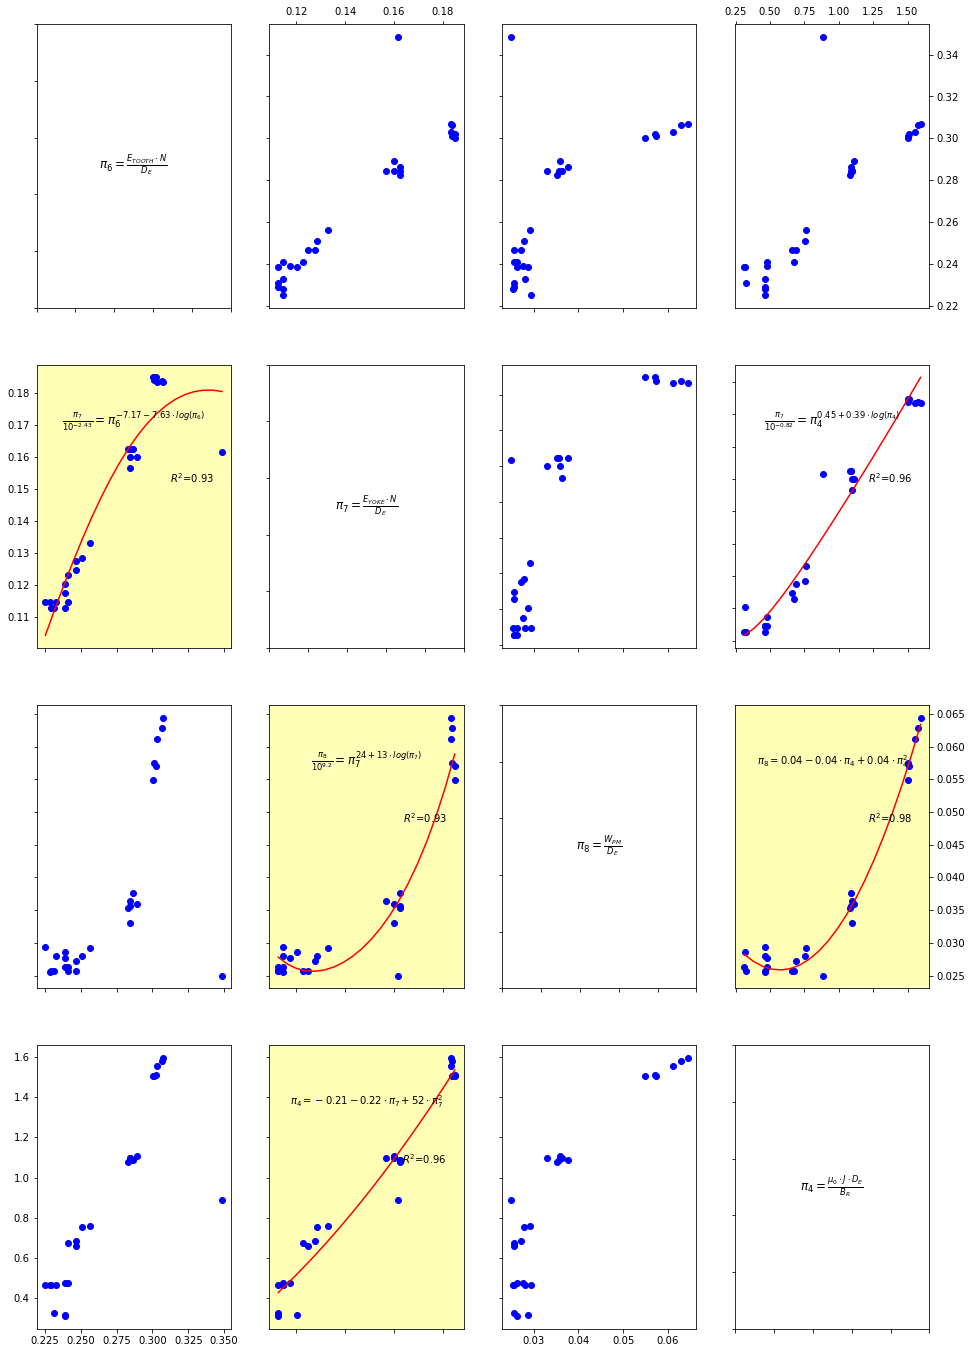

In [8]:
# Change matplotlib visualisation parameter
%matplotlib inline

# Import Sizing Lab modules
from pyvplm.addon.variablepowerlaw import pi_dependency

# Perform dependency analysis
pi_dependency(pi_set, doePI, useWidgets=True)

> Remark (order 1-3): $\pi_8$ is lightly correlated to $\pi_4$ but we can considerate all remaining parameters constant.